<a href="https://colab.research.google.com/github/aquibjaved/Bits_and_Pieces_DL/blob/main/Basics_of_lora_implementation-part-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install graphviz
!pip install torchviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=d2e75ddd6631d73c259809e4992b50bf273bfaae12cfb7314470d07781a677e3
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.nn.utils.parametrize as P
from sklearn.datasets import load_iris
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import math
from torchviz import make_dot

In [ ]:
def prepare_dataset(data, target):
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target)
  # Convert the data and target to torch tensors
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)

  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.long)


  # Create a TensorDataset and DataLoader
  dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
  loader_train = DataLoader(dataset_train, batch_size=4, shuffle=True)

  dataset_test = TensorDataset(X_test_tensor, y_test_tensor)
  loader_test = DataLoader(dataset_test, batch_size=4, shuffle=True)

  return loader_train, loader_test


def plot_loss(smoothed_train_loss, smoothed_test_loss):

  # Now plot the smoothed data
  plt.figure(figsize=(5, 5))
  plt.plot(smoothed_train_loss, label='Smoothed Training Loss')
  plt.plot(smoothed_test_loss, label='Smoothed Validation Loss')
  # Adjust the x-axis labels to account for the reduced size of the smoothed data
  plt.xlabel('Epochs (adjusted)')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()



def compute_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    labels = []
    with torch.no_grad():  # Disable gradient computation
        for data_batch, target_batch in data_loader:
            # Pass the data through the model
            outputs = model(data_batch)
            # Get the predicted class labels
            _, predicted_labels = torch.max(outputs, dim=1)
            # Update the counts of correct and total predictions
            correct_preds += (predicted_labels == target_batch).sum().item()
            total_preds += target_batch.size(0)

    # Compute the accuracy
    accuracy = correct_preds / total_preds
    return accuracy

def moving_average(data, window_size):
    """Compute a moving average over the data with the specified window size."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

In [ ]:

class MyBiGNet(nn.Module):
  def __init__(self, input_dims, num_class):
    super().__init__()
    self.input_dims = input_dims
    self.num_class = num_class
    self.input_layer = nn.Linear(in_features=self.input_dims, out_features=16)
    self.hidden_layer = nn.Linear(in_features=16, out_features=8)
    self.fc = nn.Linear(in_features=8, out_features=self.num_class)

  def forward(self, x):
    out = F.relu(self.input_layer(x))
    out = F.relu(self.hidden_layer(out))
    out = self.fc(out)
    return out


In [ ]:
def train_model(epochs:int, train_loader, test_loader, model, optimizer, criterion):
  train_loss_per_epoch = []
  test_loss_per_epoch = []

  for epoch in range(epochs):
    model.train()
    running_loss_train = 0.0

    for data_batch, target_batch in train_loader:
        optimizer.zero_grad()
        output = model(data_batch)
        loss_train = criterion(output, target_batch)
        loss_train.backward()
        optimizer.step()
        running_loss_train += loss_train.item()

    epcoh_loss_train = running_loss_train / len(train_loader)

    train_loss_per_epoch.append(epcoh_loss_train)

    model.eval()
    running_loss_test = 0.0

    with torch.no_grad():
        for data_batch, target_batch in test_loader:

            output = model(data_batch)
            loss_test = criterion(output, target_batch)
            running_loss_test += loss_test.item()

    epoch_loss_val = running_loss_test / len(test_loader)

    if epoch % 20 == 0:
      print(f'Epoch {epoch} Train loss {epcoh_loss_train}: Test loss {epoch_loss_val}')

    test_loss_per_epoch.append(epoch_loss_val)

  return train_loss_per_epoch, test_loss_per_epoch


In [ ]:

# PENGUIN DATA
import pandas as pd

penguins_df = pd.read_csv("/content/penguins-clean-all.csv.1")

#change string value to numeric
penguins_df.loc[penguins_df['species']=='Adelie', 'species']=0
penguins_df.loc[penguins_df['species']=='Gentoo', 'species']=1
penguins_df.loc[penguins_df['species']=='Chinstrap', 'species']=2
penguins_df = penguins_df.apply(pd.to_numeric)

#change dataframe to array
datatrain_array = penguins_df.values

#split x and y (feature and target)
features = datatrain_array[:,1:]
target = datatrain_array[:,0]


In [ ]:
penguins_df.shape

(342, 5)

In [ ]:
BigGeneralModel = MyBiGNet(input_dims=4, num_class=3)

optimizer = optim.SGD(BigGeneralModel.parameters(), lr=0.011, momentum=0.9)
criterion = nn.CrossEntropyLoss()

trainable_params = sum(p.numel() for p in BigGeneralModel.parameters() if p.requires_grad)
print(f'Number of trainable (tunable) parameters: {trainable_params}')


Number of trainable (tunable) parameters: 243


Epoch 0 Train loss 0.9284091319726862: Test loss 0.48663923889398575
Epoch 20 Train loss 0.08762071850280856: Test loss 0.08061399994080097
Epoch 40 Train loss 0.012530672362819805: Test loss 0.01295209955873765
Epoch 60 Train loss 0.008706768730221533: Test loss 0.011782954028401744
Epoch 80 Train loss 0.011320791806350693: Test loss 0.0023859001992434514
Epoch 100 Train loss 0.006711883271849676: Test loss 0.012419585072174123
Epoch 120 Train loss 0.005368891779587152: Test loss 0.015733223665834198
Epoch 140 Train loss 0.006000980733262223: Test loss 0.004074318012980329
Epoch 160 Train loss 0.005111489021214853: Test loss 0.011654428608075109
Epoch 180 Train loss 0.005629426652986177: Test loss 0.021163266110105796


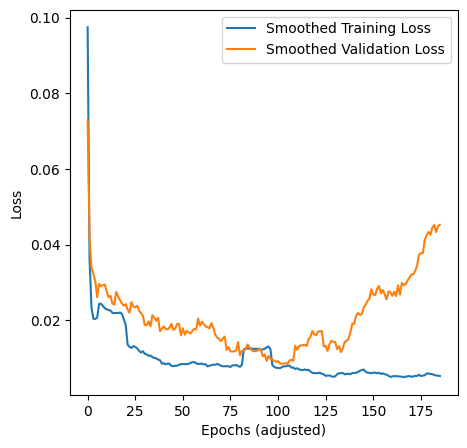

Accuracy: 98.55%


In [ ]:

#standardize
#palmer-penguin dataset has varying scales
scaler = StandardScaler()
data = scaler.fit_transform(features)

# Train model
loader_train, loader_test = prepare_dataset(data, target)
trainLoss, test_loss = train_model(epochs=200, train_loader=loader_train, test_loader=loader_test, optimizer = optimizer, criterion=criterion,  model=BigGeneralModel)

window_size = 15 # for moving avg

smoothed_train_loss = moving_average(trainLoss, window_size)
smoothed_test_loss = moving_average(test_loss, window_size)

plot_loss(smoothed_train_loss, smoothed_test_loss)

# Assume model and test_loader are defined as in your previous code
accuracy = compute_accuracy(BigGeneralModel, loader_test)
print(f'Accuracy: {accuracy * 100:.2f}%')


In [ ]:
torch.zeros(2, 5)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:
total_parameters_original = 0
for index, layer in enumerate([BigGeneralModel.input_layer, BigGeneralModel.hidden_layer, BigGeneralModel.fc]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([16, 4]) + B: torch.Size([16])
Layer 2: W: torch.Size([8, 16]) + B: torch.Size([8])
Layer 3: W: torch.Size([3, 8]) + B: torch.Size([3])
Total number of parameters: 243


In [ ]:
# saving the original model weights

original_weights = {}
for name, parm in BigGeneralModel.named_parameters():
  original_weights[name] = parm.clone()

In [ ]:
original_weights

In [ ]:
class LoRaParametarization(nn.Module):

    def __init__(self, r: int, lora_alpha: int, feature_in: int, feature_out:int):
        super().__init__()
        self.r = r
        self.lora_alpha = lora_alpha

        self.lora_A = nn.Parameter(torch.zeros(r, feature_out))
        self.lora_B = nn.Parameter(torch.zeros(feature_in, r))
        nn.init.normal_(self.lora_A, mean=0, std=1)

        self.scale = self.lora_alpha / self.r
        self.lora_enabled = True

    def forward(self, original_weights):

      if self.lora_enabled:
        return original_weights + torch.matmul(self.lora_B , self.lora_A).view(original_weights.shape) * self.scale

      return original_weights


def linear_layer_parameterization(layer, r:int=1, lora_alpha:int=1):

  feature_in, feature_out = layer.weight.shape

  return LoRaParametarization(r=r, lora_alpha=lora_alpha, feature_in=feature_in, feature_out=feature_out)

P.register_parametrization(BigGeneralModel.input_layer, "weight", linear_layer_parameterization(BigGeneralModel.input_layer))
P.register_parametrization(BigGeneralModel.hidden_layer, "weight", linear_layer_parameterization(BigGeneralModel.hidden_layer))
P.register_parametrization(BigGeneralModel.fc, "weight", linear_layer_parameterization(BigGeneralModel.fc))

def enable_disable_lora(enabled=True):
  for layer in [BigGeneralModel.input_layer, BigGeneralModel.hidden_layer, BigGeneralModel.fc]:
    layer.parametrizations["weight"][0].enabled = enabled

In [ ]:
total_parameters_lora = 0
total_parameters_non_lora = 0
for index, layer in enumerate([BigGeneralModel.input_layer, BigGeneralModel.hidden_layer, BigGeneralModel.fc]):
    total_parameters_lora += layer.parametrizations["weight"][0].lora_A.nelement() + layer.parametrizations["weight"][0].lora_B.nelement()
    total_parameters_non_lora += layer.weight.nelement() + layer.bias.nelement()
    print(
        f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape} + Lora_A: {layer.parametrizations["weight"][0].lora_A.shape} + Lora_B: {layer.parametrizations["weight"][0].lora_B.shape}'
    )
# The non-LoRA parameters count must match the original network
assert total_parameters_non_lora == total_parameters_original
print(f'Total number of parameters (original): {total_parameters_non_lora:,}')
print(f'Total number of parameters (original + LoRA): {total_parameters_lora + total_parameters_non_lora:,}')
print(f'Parameters introduced by LoRA: {total_parameters_lora:,}')
parameters_incremment = (total_parameters_lora / total_parameters_non_lora) * 100
print(f'Parameters incremment: {parameters_incremment:.3f}%')

Layer 1: W: torch.Size([16, 4]) + B: torch.Size([16]) + Lora_A: torch.Size([1, 4]) + Lora_B: torch.Size([16, 1])
Layer 2: W: torch.Size([8, 16]) + B: torch.Size([8]) + Lora_A: torch.Size([1, 16]) + Lora_B: torch.Size([8, 1])
Layer 3: W: torch.Size([3, 8]) + B: torch.Size([3]) + Lora_A: torch.Size([1, 8]) + Lora_B: torch.Size([3, 1])
Total number of parameters (original): 243
Total number of parameters (original + LoRA): 298
Parameters introduced by LoRA: 55
Parameters incremment: 22.634%


In [ ]:
enable_disable_lora(enabled=True)

In [ ]:
# Check that the frozen parameters are still unchanged by the finetuning
assert torch.all(BigGeneralModel.input_layer.parametrizations.weight.original == original_weights['input_layer.weight'])
assert torch.all(BigGeneralModel.hidden_layer.parametrizations.weight.original == original_weights['hidden_layer.weight'])
assert torch.all(BigGeneralModel.fc.parametrizations.weight.original == original_weights['fc.weight'])

enable_disable_lora(enabled=True)
# The new linear1.weight is obtained by the "forward" function of our LoRA parametrization
# The original weights have been moved to net.linear1.parametrizations.weight.original
# More info here: https://pytorch.org/tutorials/intermediate/parametrizations.html#inspecting-a-parametrized-module
# assert torch.equal(BigGeneralModel.input_layer.weight, BigGeneralModel.input_layer.parametrizations.weight.original + (BigGeneralModel.input_layer.parametrizations.weight[0].lora_B @ BigGeneralModel.hidden_layer.parametrizations.weight[0].lora_A) * BigGeneralModel.hidden_layer.parametrizations.weight[0].scale)

enable_disable_lora(enabled=False)
# If we disable LoRA, the linear1.weight is the original one
assert torch.equal(BigGeneralModel.hidden_layer.weight, original_weights['hidden_layer.weight'])


In [ ]:
enable_disable_lora(enabled=True)


MyBiGNet(
  (input_layer): ParametrizedLinear(
    in_features=4, out_features=16, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0-1): 2 x LoRaParametarization()
      )
    )
  )
  (hidden_layer): ParametrizedLinear(
    in_features=16, out_features=8, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0-1): 2 x LoRaParametarization()
      )
    )
  )
  (fc): ParametrizedLinear(
    in_features=8, out_features=3, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0-1): 2 x LoRaParametarization()
      )
    )
  )
)

In [ ]:
# Freeze the non-Lora parameters
for name, param in BigGeneralModel.named_parameters():
    if 'lora' not in name:
        print(f'Freezing non-LoRA parameter {name}')
        param.requires_grad = False



# Train the network with LoRA only on the digit 9 and only for 100 batches (hoping that it would improve the performance on the digit 9)
# train(train_loader, net, epochs=1, total_iterations_limit=100)

Freezing non-LoRA parameter input_layer.bias
Freezing non-LoRA parameter input_layer.parametrizations.weight.original
Freezing non-LoRA parameter hidden_layer.bias
Freezing non-LoRA parameter hidden_layer.parametrizations.weight.original
Freezing non-LoRA parameter fc.bias
Freezing non-LoRA parameter fc.parametrizations.weight.original


Epoch 0 Train loss 18.80442433357239: Test loss 18.300975441932678
Epoch 20 Train loss 18.80442433357239: Test loss 18.300976037979126
Epoch 40 Train loss 18.804424174626668: Test loss 17.240384832024574
Epoch 60 Train loss 18.804424341519674: Test loss 17.855796366930008
Epoch 80 Train loss 18.80442419052124: Test loss 18.33697783946991
Epoch 100 Train loss 18.804424319263976: Test loss 17.836857110261917
Epoch 120 Train loss 18.804424397150676: Test loss 19.05339753627777
Epoch 140 Train loss 18.804424254099526: Test loss 18.916388034820557
Epoch 160 Train loss 18.80442429141452: Test loss 18.377208828926086
Epoch 180 Train loss 18.80442452430725: Test loss 17.6412273645401


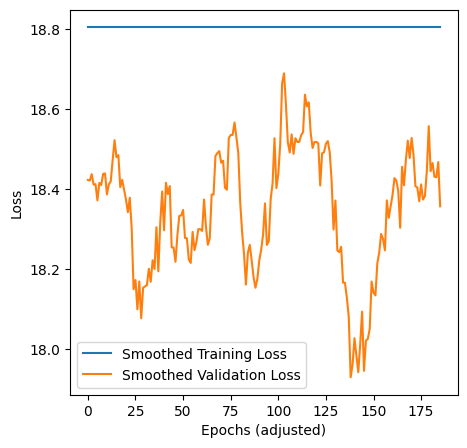

Accuracy: 33.33%


In [ ]:
# Load the Iris dataset
iris = load_iris()
data, target = iris.data, iris.target

# Train model
loader_train, loader_test = prepare_dataset(data, target)
trainLoss, test_loss = train_model(epochs=200, train_loader=loader_train, test_loader=loader_test, optimizer = optimizer, criterion=criterion,  model=BigGeneralModel)

window_size = 15 # for moving avg

smoothed_train_loss = moving_average(trainLoss, window_size)
smoothed_test_loss = moving_average(test_loss, window_size)

plot_loss(smoothed_train_loss, smoothed_test_loss)

# Assume model and test_loader are defined as in your previous code
accuracy = compute_accuracy(BigGeneralModel, loader_test)
print(f'Accuracy: {accuracy * 100:.2f}%')


In [ ]:
penguins_df

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181,3750
1,Adelie,39.5,17.4,186,3800
2,Adelie,40.3,18.0,195,3250
3,Adelie,36.7,19.3,193,3450
4,Adelie,39.3,20.6,190,3650
...,...,...,...,...,...
337,Chinstrap,55.8,19.8,207,4000
338,Chinstrap,43.5,18.1,202,3400
339,Chinstrap,49.6,18.2,193,3775
340,Chinstrap,50.8,19.0,210,4100
